## Get Data

In [126]:
import pandas as pd
import requests
import seaborn as sns
import re
from whatthelang import WhatTheLang
import jellyfish

In [21]:
URL = "https://keralarescue.in/data/"

In [22]:
df = pd.read_json(requests.get(url).text)

In [23]:
df.head(2)

,dateadded,detailcloth,detailfood,detailkit_util,detailmed,detailrescue,detailtoilet,detailwater,district,id,...,needkit_util,needmed,needothers,needrescue,needtoilet,needwater,requestee,requestee_phone,status,supply_details
0,2018-08-16T09:17:58.895Z,,,,,,,,ekm,6765,...,False,False,Rescue from water filled house,False,False,False,Sreeram,094470581,new,
1,2018-08-16T09:21:22.609Z,,,,,,,,idk,6794,...,False,False,,False,False,False,Test,Test,new,


In [26]:
df.columns

Index([u'dateadded', u'detailcloth', u'detailfood', u'detailkit_util',
       u'detailmed', u'detailrescue', u'detailtoilet', u'detailwater',
       u'district', u'id', u'is_request_for_others', u'latlng',
       u'latlng_accuracy', u'location', u'needcloth', u'needfood',
       u'needkit_util', u'needmed', u'needothers', u'needrescue',
       u'needtoilet', u'needwater', u'requestee', u'requestee_phone',
       u'status', u'supply_details'],
      dtype='object')

- We have the above columns available

## Distribution of requests  across districts

In [71]:
df.location.value_counts()

Aluva                                                                                                                                                                         108
Chengannur                                                                                                                                                                     98
Chalakudy                                                                                                                                                                      89
Thiruvalla                                                                                                                                                                     64
Kalady                                                                                                                                                                         54
Poovathussery                                                                                                 

In [67]:
df[["location","latlng"]].head(5)

,location,latlng
0,East kadangallur,"10.0021295,76.3230197"
1,Test,"10.7208157,76.6447006"
2,Muvattupuzha,"9.7370423,77.155886"
3,Thuravankara,"10.3470498,76.2086201"
4,Punnackadu,"8.5565307,76.8810618"


In [46]:
val_counts = df.district.value_counts()
val_counts

ekm    2813
ptm    1548
alp    1468
tcr    1209
idk      52
ktm      29
tvm      28
kol      23
mpm      21
koz      15
pkd      15
knr       6
wnd       5
ksr       5
Name: district, dtype: int64

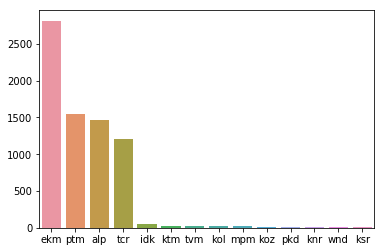

In [47]:
sns.barplot(x=val_counts.index, y=val_counts.values)

- As evident from the distribution ; **Ernakulam** (ekm), **Pathanamathitta** (ptm) , **Alappuzha** (alp) and **Thrissur** (tcr) 
  looks like the most affected districts.

In [48]:
df.shape

(7237, 26)

- We have at this point of time 7237 requests being made.

# Utility functions

In [50]:
PHONE_NUM_REGEX = "^(?:(?:\+|0{0,2})91(\s*[\-]\s*)?|[0]?)?[789]\d{9}$"
pattern = re.compile(PHONE_NUM_REGEX) 
lat_range = (8,10)
lng_range = (74,78)

In [100]:
def is_valid_num(ph_no): 
    return bool(re.match(pattern,ph_no)) 

In [101]:
def is_valid_kerala_lat_long(lat,lng):
    return 8 <= lat <= 9 and 74<= lng <=78


In [102]:
wtl = WhatTheLang()
def identify_lang(text): 
    try :
        return wtl.predict_lang(text)
    except ValueError:
        return "NA"
        

# Cleanup

In [84]:
print "Total Number of request is {}".format(df.shape[0])
print "Total Unique requests is {}".format(df.requestee_phone.unique().shape[0])

Total Number of request is 7237
Total Unique requests is 5505


- We have duplicates and should be removed. More discussion happened [here](https://github.com/IEEEKeralaSection/rescuekerala/issues/419) about this. 

In [86]:
cleaned_df = df.copy()

In [90]:
cleaned_df = cleaned_df.drop_duplicates(subset='requestee_phone')

In [93]:
print "Total requests after removing the duplicate phone numbers : {}".format(cleaned_df.shape[0])

Total requests after removing the duplicate phone numbers : 5505


In [94]:
cleaned_df["is_valid_phone"]= cleaned_df.apply(lambda x : is_valid_num(x["requestee_phone"]),axis =1)

/home/krishna/miniconda2/envs/citius/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [95]:
cleaned_df.is_valid_phone.value_counts()

True     5177
False     328
Name: is_valid_phone, dtype: int64

In [96]:
cleaned_df = cleaned_df[cleaned_df.is_valid_phone]

In [98]:
print "Total requests after removing the invalid phone numbers : {}".format(cleaned_df.shape[0])

Total requests after removing the invalid phone numbers : 5177


In [103]:
cleaned_df["language"] = cleaned_df.apply(lambda x : identify_lang(x["location"]),axis =1)

In [108]:
cleaned_df_ml = cleaned_df[cleaned_df.language == "ml"]

In [111]:
print "Number of requests made in Malayalam is : {}. \
These need to be handled differently".format(cleaned_df_ml.shape[0])

Number of requests made in Malayalam is : 178. These need to be handled differently


In [112]:
cleaned_df = cleaned_df[cleaned_df.language != "ml"]

In [120]:
cleaned_df.location.value_counts()[:10]

Aluva              78
Chengannur         67
Chalakudy          60
Thiruvalla         50
Kalady             41
Poovathussery      36
Pandanad           30
Ayroor             17
chengannur         17
Thiruvanvandoor    15
Name: location, dtype: int64

- We can see that there are duplicates and typos in the location names. We need to handle basic typos.

In [122]:
cleaned_df["location"] = cleaned_df.location.apply(lambda x : x.lower())

In [125]:
cleaned_df.location.value_counts()[:200]

chengannur                                                                96
aluva                                                                     95
chalakudy                                                                 70
thiruvalla                                                                61
kalady                                                                    50
poovathussery                                                             41
pandanad                                                                  35
thiruvanvandoor                                                           20
north paravur                                                             20
chalakkudy                                                                19
ayroor                                                                    18
chendamangalam                                                            17
niranam                                                                   16

- We can see that Chengannur is clearly one of the most affected. But can also see places mentioned as `chegannur` etc ; We can try to do use some distance metric to find the ones which are obvious typo

In [130]:
jellyfish.jaro_distance(u"chengannur",u"chegannur")

0.9296296296296296

- Jaro distance seems to be a good metric here. We can try to find the closest matching string to the 
below locations (top 15)
       u'chengannur', u'aluva', u'chalakudy', u'thiruvalla', u'kalady',
       u'poovathussery', u'pandanad', u'thiruvanvandoor', u'north paravur',
       u'chalakkudy', u'ayroor', u'chendamangalam', u'niranam', u'kadukutty',
       u'arattupuzha'

In [144]:
all_location = cleaned_df.location.unique().tolist()

In [138]:
top_15_loc = cleaned_df.location.value_counts()[:15].index.tolist()
top_15_loc

[u'chengannur',
 u'aluva',
 u'chalakudy',
 u'thiruvalla',
 u'kalady',
 u'poovathussery',
 u'pandanad',
 u'thiruvanvandoor',
 u'north paravur',
 u'chalakkudy',
 u'ayroor',
 u'chendamangalam',
 u'niranam',
 u'kadukutty',
 u'arattupuzha']

In [157]:
def build_mapping(all_location,top_15_loc):
    loc_mapping = {}
    for loc in all_location:
        for tloc in top_15_loc:
            max_dist = 0
            if loc == tloc:
                continue
            else:
                sim = jellyfish.jaro_distance(loc,tloc)
                if sim > 0.85 and sim > loc_mapping.get("loc",0):
                    loc_mapping[loc] = tloc
    return loc_mapping

In [159]:
loc_mapping = build_mapping(all_location,top_15_loc)
loc_mapping

{u'aaraattupuzha': u'arattupuzha',
 u'aarattupuhza': u'arattupuzha',
 u'aarattupuzha': u'arattupuzha',
 u'aaratupuzha': u'arattupuzha',
 u'aliva': u'aluva',
 u'aluva,': u'aluva',
 u'aratpuzha': u'arattupuzha',
 u'arattupuza': u'arattupuzha',
 u'arattupuzha bridge': u'arattupuzha',
 u'aratuppuzha': u'arattupuzha',
 u'aratupuzha': u'arattupuzha',
 u'ayiroor': u'ayroor',
 u'chalakka': u'chalakkudy',
 u'chalakkkudy': u'chalakkudy',
 u'chalakkudi': u'chalakkudy',
 u'chalakkudy': u'chalakudy',
 u'chalakkudy south': u'chalakkudy',
 u'chalakuddy': u'chalakkudy',
 u'chalakudi': u'chalakkudy',
 u'chalakudy': u'chalakkudy',
 u'chalakudy meloor': u'chalakudy',
 u'chalakudy,meloor': u'chalakudy',
 u'chegannur': u'chengannur',
 u'chenagnnur': u'chengannur',
 u'chendamangalam panchayath': u'chendamangalam',
 u'chendamangalam paravur': u'chendamangalam',
 u'chendamangalam, paravoor': u'chendamangalam',
 u'chendamangalam, paravur': u'chendamangalam',
 u'chengamanad': u'chendamangalam',
 u'chengannoor':

- Mapping Looks good. We will map these locations also to the top 15 locations

In [160]:
def map_location(location): return loc_mapping.get(location,location)

In [161]:
cleaned_df["new_location"] = cleaned_df.apply(lambda x : map_location(x["location"]),axis =1)

In [163]:
cleaned_df.new_location.value_counts()[:20]

chengannur           141
aluva                 97
chalakkudy            95
thiruvalla            68
kalady                59
poovathussery         53
pandanad              51
thiruvanvandoor       38
north paravur         31
chalakudy             28
arattupuzha           27
chendamangalam        26
ayroor                23
niranam               17
kadukutty             17
east kadungalloor     14
kongorpilly           14
aranmula              14
edayaranmula          13
budhanoor             12
Name: new_location, dtype: int64

In [ ]:
- This is the Top 20 affected locations along with number of requests